# Playground: WanX VAE Wrapper

This notebook demonstrates how to use the `WanxVAEWrapper` defined in `websocket_server/worker.py` to encode and decode Matrix-Game frames. It mirrors the websocket worker preprocessing so you can inspect latent tensors, reconstructions, and CLIP embeddings interactively.

## Setup Notes
- Expect the Wan 2.1 VAE checkpoint (`Wan2.1_VAE.pth`), CLIP weights, and tokenizer assets in the project root as described in `Matrix-Game-2/README.md`.
- A CUDA GPU is recommended; if you run on CPU the notebook falls back to `float32` and execution will be noticeably slower.
- Key references while exploring:
  - `websocket_server/worker.py` (wrapper glue code and tiling settings)
  - `demo_utils/vae_block3.py` (decoder helper used in streaming inference)
  - `utils/visualize.py` (post-processing helpers for generated frames)

In [1]:
from pathlib import Path

import torch
from PIL import Image
from torchvision.transforms import v2
from IPython.display import display

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
PROJECT_ROOT = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
MODEL_DIR = PROJECT_ROOT  # Wan VAE and CLIP checkpoints live under the repo root
REFERENCE_FRAME = PROJECT_ROOT / "demo_images" / "universal" / "0000.png"

print(f"Project root: {PROJECT_ROOT}")
print(f"Reference frame: {REFERENCE_FRAME}")
print("Current Workding Dir", Path.cwd())

if not REFERENCE_FRAME.exists():
    raise FileNotFoundError("Missing reference frame for the VAE playground demo.")

REQUIRED_ARTIFACTS = [
    MODEL_DIR / "Wan2.1_VAE.pth",
    MODEL_DIR / "models_clip_open-clip-xlm-roberta-large-vit-huge-14.pth",
    MODEL_DIR / "xlm-roberta-large",
]
for artifact in REQUIRED_ARTIFACTS:
    if not artifact.exists():
        print(f"[warning] Missing expected artifact: {artifact}")

Project root: /home/ubuntu/workspace/Matrix-Game
Reference frame: /home/ubuntu/workspace/Matrix-Game/demo_images/universal/0000.png
Current Workding Dir /home/ubuntu/workspace/Matrix-Game


In [3]:
from vae.model import WanVAEWrapper
import os

weight_dtype = torch.float16
model_path = PROJECT_ROOT

vae_model = WanVAEWrapper(
    pretrained_path=os.path.join(model_path, "Wan2.1_VAE.pth")
).to(weight_dtype)

/home/ubuntu/.conda/envs/matrix-game-2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'WanVAEWrapper' from 'vae.model' (/home/ubuntu/workspace/Matrix-Game/vae/model.py)

In [6]:
# test clip model
import os
from modules import clip

clip_model = clip.CLIPModel(
    dtype=torch.float16,
    device="cuda",
    checkpoint_path=os.path.join(
        str(MODEL_DIR), "models_clip_open-clip-xlm-roberta-large-vit-huge-14.pth"
    ),
    tokenizer_path=os.path.join(str(MODEL_DIR), "xlm-roberta-large"),
)

In [4]:
try:
    from modules.pipeline import get_wanx_vae_wrapper
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "Import failed. Ensure Matrix-Game dependencies (including TensorRT bindings) are installed before running the notebook."
    ) from exc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weight_dtype = torch.float16 if device.type == "cuda" else torch.float32

vae_wrapper = get_wanx_vae_wrapper(str(MODEL_DIR), weight_dtype)
vae_wrapper = vae_wrapper.to(device, weight_dtype)

if hasattr(vae_wrapper.vae, "eval"):
    vae_wrapper.vae.eval()
if getattr(vae_wrapper, "clip", None) is not None and hasattr(vae_wrapper.clip, "eval"):
    vae_wrapper.clip.eval()

print(f"Using device: {device}")
print(f"Latent dtype: {weight_dtype}")

AttributeError: module 'modules.vae' has no attribute 'WanVAE'

## Load and Preprocess a Reference Frame
The worker normalizes frames to the `[-1, 1]` range with a resize to `(352, 640)` before hitting the Wan VAE encoder. We keep the same transform and pad the clip with dummy frames to mirror streaming usage.

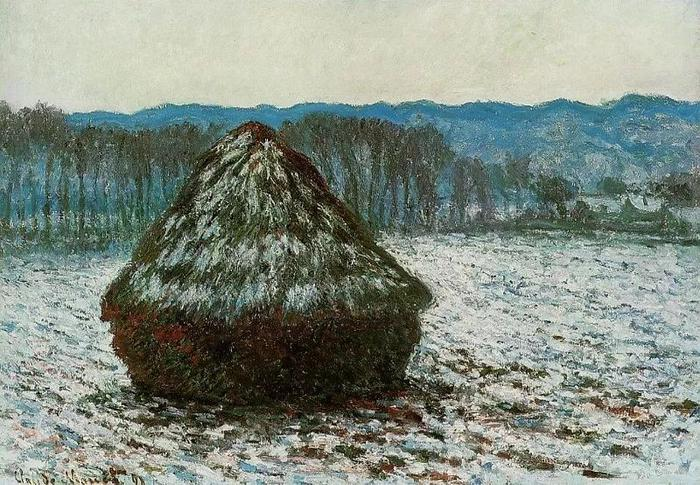

In [10]:
Image.open(REFERENCE_FRAME)

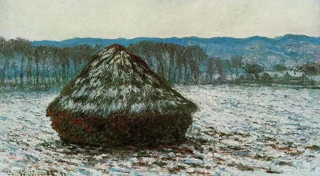

Condition tensor shape: torch.Size([1, 3, 5, 352, 640])


In [15]:
frame_transform = v2.Compose(
    [
        v2.Resize(size=(352, 640), antialias=True),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
max_num_output_frames = 5  # tweak to explore different clip lengths

reference_image = Image.open(REFERENCE_FRAME).convert("RGB")
display(reference_image.resize((320, 176)))  # quick visual sanity check

video_tensor = frame_transform(reference_image)[None, :, None, :, :]
padding = torch.zeros(
    (
        video_tensor.shape[0],
        video_tensor.shape[1],
        max_num_output_frames - 1,
        video_tensor.shape[-2],
        video_tensor.shape[-1],
    ),
    device=device,
    dtype=weight_dtype,
)
video_condition = torch.cat(
    [video_tensor.to(device=device, dtype=weight_dtype), padding], dim=2
)

tiler_kwargs = {
    "tiled": True,
    "tile_size": (44, 80),
    "tile_stride": (23, 38),
}

print(f"Condition tensor shape: {video_condition.shape}")

## Encode Frames into Wan Latents

In [ ]:
with torch.no_grad():
    latents = vae_wrapper.encode(video_condition, device=device, **tiler_kwargs)

print(f"Latent shape: {tuple(latents.shape)}")
print(
    f"Latent stats — dtype: {latents.dtype}, min: {latents.min().item():.3f}, max: {latents.max().item():.3f}"
)

## Decode Latents Back to Pixels

In [ ]:
with torch.no_grad():
    recon = vae_wrapper.decode(latents, device=device, **tiler_kwargs)

recon_tensor = recon
if isinstance(recon, (list, tuple)):
    recon_tensor = recon[0]

recon_tensor = recon_tensor.to(torch.float32).cpu()
print(f"Reconstruction tensor shape: {tuple(recon_tensor.shape)}")

recon_frame = recon_tensor[0, :, 0]
recon_image = ((recon_frame.permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1)
recon_np = (recon_image.numpy() * 255).astype("uint8")
display(Image.fromarray(recon_np))

## Compare Reconstruction to Normalized Input

In [ ]:
import torch.nn.functional as F

original_frame = video_condition[0, :, 0].detach().to(torch.float32).cpu()
recon_frame_normalized = recon_tensor[0, :, 0]

mse = F.mse_loss(recon_frame_normalized, original_frame)
psnr = -10.0 * torch.log10(mse)

print(f"MSE (normalized space): {mse.item():.6f}")
print(f"PSNR (normalized space): {psnr.item():.2f} dB")

## Inspect CLIP Conditioning Features

In [ ]:
if getattr(vae_wrapper, "clip", None) is None:
    print("CLIP encoder not attached to the wrapper; skipping feature extraction.")
else:
    with torch.no_grad():
        clip_embeddings = vae_wrapper.clip.encode_video(video_condition)

    print(f"CLIP embedding shape: {tuple(clip_embeddings.shape)}")
    print(
        f"Feature slice (first 8 dims): {clip_embeddings[0, 0, :8].detach().cpu().numpy()}"
    )

## Next Steps
- Swap `REFERENCE_FRAME` or adjust `max_num_output_frames` to profile longer clips.
- Feed the latents into `pipeline.CausalInferenceStreamingPipeline` to observe end-to-end generation.
- Experiment with `tiler_kwargs` (tile size/stride) to study reconstruction fidelity versus throughput.